<a href="https://colab.research.google.com/github/kaiji123/MistralFinanceGuider/blob/master/FinetuneMistral2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# (Optional) Check CUDA version
!nvidia-smi

Fri Nov  7 04:29:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 39.9 MB/s eta 0:00:00


In [5]:
import bitsandbytes as bnb
print("BitsAndBytes version:", bnb.__version__)


BitsAndBytes version: 0.48.2


In [7]:
# ============================================================
# Colab-ready Mistral 7B 4-bit LoRA fine-tuning script
# ============================================================

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from accelerate import dispatch_model
import torch
import gc

print("="*60)
print("🚀 Starting FAST Mistral Fine-tuning with 4-bit Quantization")
print("="*60)

# ============================================================
# 0. Environment check
# ============================================================
print("\nChecking GPU availability...")
if not torch.cuda.is_available():
    raise SystemError("❌ No GPU detected! Install CUDA-enabled PyTorch.")
print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
print(f"   Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================================
# 1. Load dataset
# ============================================================
print("\n" + "="*60)
print("Step 1: Loading and sampling dataset...")
print("="*60)

dataset = load_dataset("Josephgflowers/Finance-Instruct-500k", split="train")
dataset = dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = dataset["train"].shuffle(seed=42).select(range(20000))
val_dataset = dataset["test"].select(range(1000))

print(f"✅ Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

# ============================================================
# 2. Format dataset
# ============================================================
print("\n" + "="*60)
print("Step 2: Formatting dataset...")
print("="*60)

def format_example(example):
    instruction = example.get("instruction", "")
    inp = example.get("input", "")
    response = example.get("response", example.get("assistant", ""))
    if inp:
        text = f"### Instruction:\n{instruction}\n\n### Input:\n{inp}\n\n### Response:\n{response}"
    else:
        text = f"### Instruction:\n{instruction}\n\n### Response:\n{response}"
    return {"text": text}

train_dataset = train_dataset.map(format_example, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(format_example, remove_columns=val_dataset.column_names)
print("✅ Dataset formatted successfully!")

# ============================================================
# 3. Load tokenizer
# ============================================================
print("\n" + "="*60)
print("Step 3: Loading tokenizer...")
print("="*60)

chosen_llm = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(chosen_llm)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"✅ Tokenizer loaded (Vocab size: {len(tokenizer)})")

gc.collect()
torch.cuda.empty_cache()

# ============================================================
# 4. Load model in 4-bit mode
# ============================================================
print("\n" + "="*60)
print("Step 4: Loading model in 4-bit mode...")
print("="*60)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    chosen_llm,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# Force full GPU placement if model was partially offloaded
if any("cpu" in str(v) for v in model.hf_device_map.values()):
    print("⚙️ Dispatching model fully to GPU...")
    model = dispatch_model(model, device_map={"": "cuda:0"})

print("✅ Model loaded successfully!")
print(model.hf_device_map)

# ============================================================
# 5. Prepare for k-bit LoRA training
# ============================================================
print("\n" + "="*60)
print("Step 5: Preparing for LoRA fine-tuning...")
print("="*60)

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
print("✅ LoRA configuration applied!")

# ============================================================
# 6. Tokenize datasets
# ============================================================
print("\n" + "="*60)
print("Step 6: Tokenizing datasets (max_length=128)...")
print("="*60)

def tokenize_fn(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

train_tokenized = train_dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
val_tokenized = val_dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

print(f"✅ Tokenization complete! Train: {len(train_tokenized)}, Val: {len(val_tokenized)}")

# ============================================================
# 7. Training Arguments
# ============================================================
print("\n" + "="*60)
print("Step 7: Setting training arguments...")
print("="*60)

training_args = TrainingArguments(
    output_dir="./mistral-lora-finance-fast",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    num_train_epochs=1,
    fp16=True,
    optim="paged_adamw_8bit",
    warmup_steps=50,
    logging_steps=50,
    eval_strategy="no",
    save_strategy="epoch",
    save_total_limit=1,
    dataloader_num_workers=0,
    report_to="none",
    torch_compile=False,
)

print("✅ Training arguments ready!")

# ============================================================
# 8. Trainer
# ============================================================
print("\n" + "="*60)
print("Step 8: Initializing Trainer...")
print("="*60)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
)

print("✅ Trainer initialized!")

# ============================================================
# 9. Train
# ============================================================
print("\n" + "="*60)
print("🔥 Step 9: Training...")
print("="*60)

trainer.train()
print("🎉 Training completed successfully!")

# ============================================================
# 10. Save
# ============================================================
print("\n" + "="*60)
print("Step 10: Saving model and tokenizer...")
print("="*60)

output_dir = "./mistral-lora-finance-adapter-fast"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model saved to: {output_dir}")
print("\n" + "="*60)
print("🏁 Fine-tuning Complete!")
print("="*60)
print(f"\nYou can now load it with:")
print(f"  from peft import PeftModel")
print(f"  base = AutoModelForCausalLM.from_pretrained('{chosen_llm}')")
print(f"  model = PeftModel.from_pretrained(base, '{output_dir}')")


🚀 Starting FAST Mistral Fine-tuning with 4-bit Quantization

Checking GPU availability...
✅ GPU: NVIDIA A100-SXM4-80GB
   Total GPU Memory: 85.17 GB

Step 1: Loading and sampling dataset...
✅ Train samples: 20000 | Val samples: 1000

Step 2: Formatting dataset...


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Dataset formatted successfully!

Step 3: Loading tokenizer...
✅ Tokenizer loaded (Vocab size: 32000)

Step 4: Loading model in 4-bit mode...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded successfully!
{'': 0}

Step 5: Preparing for LoRA fine-tuning...
trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470
✅ LoRA configuration applied!

Step 6: Tokenizing datasets (max_length=128)...


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Tokenization complete! Train: 20000, Val: 1000

Step 7: Setting training arguments...
✅ Training arguments ready!

Step 8: Initializing Trainer...
✅ Trainer initialized!

🔥 Step 9: Training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
50,1.793600
100,1.433200
150,1.300600
200,1.338200
250,1.344800
300,1.297300
350,1.345500
400,1.245000
450,1.280400
500,1.373200


🎉 Training completed successfully!

Step 10: Saving model and tokenizer...
✅ Model saved to: ./mistral-lora-finance-adapter-fast

🏁 Fine-tuning Complete!

You can now load it with:
  from peft import PeftModel
  base = AutoModelForCausalLM.from_pretrained('mistralai/Mistral-7B-v0.1')
  model = PeftModel.from_pretrained(base, './mistral-lora-finance-adapter-fast')


In [8]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copytree("./mistral-lora-finance-adapter-fast", "/content/drive/MyDrive/mistral_lora_model")


MessageError: Error: credential propagation was unsuccessful

In [10]:
# ============================================================
# Inference / Results with fine-tuned Mistral 7B LoRA
# ============================================================

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Path to your saved LoRA adapter
lora_path = "./mistral-lora-finance-adapter-fast"
base_model_name = "mistralai/Mistral-7B-v0.1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load base model in 4-bit (efficient for Colab)
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("Loading base model in 4-bit...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Load LoRA adapter
print("Loading LoRA adapter...")
model = PeftModel.from_pretrained(base_model, lora_path)
model.eval()

# ============================================================
# Function to generate text
# ============================================================

def generate(prompt, max_new_tokens=128, temperature=0.7, top_p=0.9):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ============================================================
# Example usage
# ============================================================

prompt = """### Instruction:
Give me 3 actionable tips to reduce monthly expenses.

### Response:"""

result = generate(prompt)
print("\n=== Generated Text ===\n")
print(result)


Loading base model in 4-bit...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading LoRA adapter...

=== Generated Text ===

### Instruction:
Give me 3 actionable tips to reduce monthly expenses.

### Response:
1. Create a budget and stick to it: Track your expenses and set a budget for each category. This will help you identify areas where you can cut costs and stick to your budget.
2. Reduce your transportation costs: Consider using public transportation or carpooling to reduce your transportation costs.
3. Cut back on eating out: Prepare your meals at home and bring them to work or school. This can save you a lot of money in the long run.

These tips can help you reduce your monthly expenses and save money. Remember to track your expenses and set a budget for each category. Good luck


📝 Generated Results

Prompt 1: Explain compound interest in simple terms.

Output:
### Instruction:
Explain compound interest in simple terms.

### Response:
Compound interest is the interest earned on both the principal amount and the accumulated interest from previous periods. It is calculated using the formula:

A = P(1 + r)^n

where:
- A is the accumulated amount after n periods
- P is the principal amount (initial investment)
- r is the annual interest rate
- n is the number of times that interest is compounded per year

For example, if you invest $1,000 at 5% annual interest, compounded quarterly, for 10 years, the total accumulated amount would be
------------------------------------------------------------

Prompt 2: Provide three investment tips for a beginner in 2025.

Output:
### Instruction:
Provide three investment tips for a beginner in 2025.

### Response:
1. Diversify your investments: Investing in a variety of assets, such as stocks, bonds, and real estate, can help re

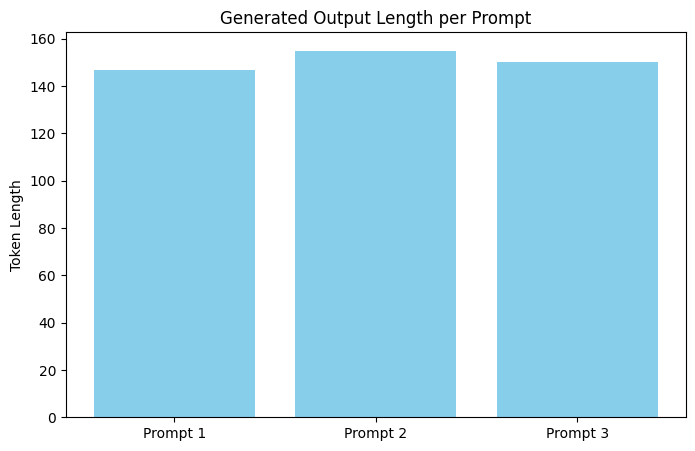

In [12]:
import matplotlib.pyplot as plt

prompts = [
    "Explain compound interest in simple terms.",
    "Provide three investment tips for a beginner in 2025.",
    "Summarize the risks of cryptocurrency trading."
]

results = []

print("📝 Generated Results\n")
for i, prompt in enumerate(prompts, 1):
    output = generate(f"### Instruction:\n{prompt}\n\n### Response:")
    results.append(output)
    print(f"Prompt {i}: {prompt}\n")
    print(f"Output:\n{output}\n{'-'*60}\n")

# Quick visualization: token length of each output
token_lengths = [len(tokenizer(res)["input_ids"]) for res in results]

plt.figure(figsize=(8,5))
plt.bar(range(1, len(prompts)+1), token_lengths, color='skyblue')
plt.xticks(range(1, len(prompts)+1), [f"Prompt {i}" for i in range(1, len(prompts)+1)])
plt.ylabel("Token Length")
plt.title("Generated Output Length per Prompt")
plt.show()


In [9]:
from google.colab import files
import shutil

shutil.make_archive("mistral-lora-finance-adapter-fast", 'zip', "./mistral-lora-finance-adapter-fast")
files.download("mistral-lora-finance-adapter-fast.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>